In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import math
from tensorflow.keras.losses import mse, mae, cosine_similarity, logcosh
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.keras.backend.clear_session()  # For easy reset of notebook state.
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## prepare data

In [3]:
'''
def make_test_train_split(df_labels, random_state=12):
    idx_train, idx_test = train_test_split(df_labels.ResultFinalCheck, test_size=0.1, random_state=random_state)

    df_train = df_labels.loc[idx_train.index].reset_index(drop=True)
    df_test = df_labels.loc[idx_test.index].reset_index(drop=True)
    
    return df_train, df_test
'''

def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    #plt.ylim(0, 50)
    for feature in ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']:
        df_curve[feature].plot(ax=ax, label=feature)
    
    ax.legend(loc='lower right')
    #ax.set_title(df_curve.name)

def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe

    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC'],
        usecols=range(7)
    )
    df.name = os.path.basename(filepath)
    df['frame'] = df.index
    df['energy'] = np.cumsum( (df.WegSpd1[1:].values - df.WegSpd1[:-1].values) * df.KraftSpd1[:-1])
    df['tag'] = df.name
    
    return df

In [4]:
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        self.window_size = 100
        
    def make_batch(self, df_sub):
        self.window_size = 100
        df_curves = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]
        '''
        X = np.array([
            #df[0:self.n_timesteps][['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']].values for df in dfs
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in df_curves
        ])
        
        X = X.std(axis=2)
        
        '''
        features = []
        
        for df_curve in df_curves:                
            gap_f = ['K7_1_TL', 'K7_2_TR', 'K7_3_BL', 'K7_4_BR','K3m_MC']
            f1 = df_curve[gap_f].iloc[:10].mean().values
                 
            w = 0.005
            index_d005 = np.logical_and( df_curve['WegSpd1'] < 0.01 + w, df_curve['WegSpd1'] > 0.01 - w)
            f2 = df_curve[gap_f][index_d005].mean().values
            
            index_d010 = np.logical_and( df_curve['WegSpd1'] < 0.05 + w, df_curve['WegSpd1'] > 0.05 - w)
            f3 = df_curve[gap_f][index_d010].mean().values
            
            index_d015 = np.logical_and( df_curve['WegSpd1'] < 0.15 + w, df_curve['WegSpd1'] > 0.15 - w)
            f4 = df_curve[gap_f][index_d015].mean().values
            
            #feature_mean = df_curve[gap_f].mean().values
            #feature_std = df_curve[gap_f].std().values
            feature_max = df_curve[gap_f].max().values

            feature_end = df_curve[gap_f].iloc[-1].values

            feature = np.r_[f1,f2,f3,feature_max,feature_end]
            #print(np.shape(feature))
            features.append(feature)
        
        return np.array(features)
        
        #return X

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [5]:
df_train = pd.read_csv('pure_train_5_pec_70_pec.csv')
#df_train, df_test = make_test_train_split(df)
df_train.shape

(51973, 2)

## Valid VAE Model

In [6]:
# model setting 
# The number of epochs at which KL loss should be included
klstart = 2
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 5

weight = tf.keras.backend.variable(0.1)
#temp = tf.keras.backend.variable(1e-10)

class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(tf.keras.backend.get_value(self.weight) + (1./ kl_annealtime), 1.)
            tf.keras.backend.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(tf.keras.backend.get_value(self.weight)))

latent_dim = 100
intermediate_dim = 100
#intermediate_dim2 = 50
final_dim = 25

# define VAE model
encoder_inputs = keras.Input(shape=(25, 1))
x = layers.Flatten()(encoder_inputs)
h = layers.Dense(intermediate_dim, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=tf.keras.regularizers.l2(1e-4),
                 activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
h = layers.BatchNormalization()(h)
#h = layers.Dense(intermediate_dim2, activation = 'relu')(h)
#h = layers.BatchNormalization()(h)
h = layers.Dense(final_dim, activation = 'relu',
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=tf.keras.regularizers.l2(1e-4),
                 activity_regularizer=tf.keras.regularizers.l2(1e-5))(h)
h = layers.BatchNormalization()(h)
h = layers.Dropout(0.5)(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = layers.Dense(final_dim, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=tf.keras.regularizers.l2(1e-4),
                         activity_regularizer=tf.keras.regularizers.l2(1e-5))
bn1 = layers.BatchNormalization()
dr = layers.Dropout(0.5)
#decoder_h2 = layers.Dense(intermediate_dim2, activation='relu')
bn2 = layers.BatchNormalization()
decoder_h = layers.Dense(intermediate_dim, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=tf.keras.regularizers.l2(1e-4),
                         activity_regularizer=tf.keras.regularizers.l2(1e-5))
bn3 = layers.BatchNormalization()
decoder_mean = layers.Dense(25*1, activation=None)

f_decoded = decoder_f(z)
f_decoded = dr(f_decoded)
f_decoded = bn1(f_decoded)
#f_decoded = decoder_h2(f_decoded)
#f_decoded = bn2(f_decoded)
f_decoded = decoder_h(f_decoded)
f_decoded = bn3(f_decoded)
x_decoded_mean = decoder_mean(f_decoded)
decoder_outputs = layers.Reshape((25, 1))(x_decoded_mean)

# instantiate VAE model
vae = keras.Model(encoder_inputs, decoder_outputs)

# Compute VAE loss
# VAE loss = mse_loss or xent_loss + kl_loss
'''
x_minus_mn_with_transpose = K.transpose(encoder_inputs - decoder_outputs)
Covariance = tfp.stats.covariance(tf.transpose(encoder_inputs))
inv_covmat = tf.linalg.inv(Covariance + temp)
x_minus_mn = encoder_inputs - decoder_outputs
left_term = K.dot(x_minus_mn, inv_covmat)
reconstruction_loss = K.dot(left_term, x_minus_mn_with_transpose)
'''

reconstruction_loss = mse(encoder_inputs, decoder_outputs) #logcosh, mse
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + weight*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
vae.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
#vae.compile(optimizer='adam')

#opt = keras.optimizers.Adam(learning_rate=0.001)
#vae.compile(optimizer=opt)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2600        flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         dense[0][0]                      
______________________________________________________________________________________________

In [7]:
#Train the VAE
generator_train = CurveSequence(df_train, batch_size=256)

#vae.fit_generator(generator_train, steps_per_epoch=200, epochs=50, workers=4, use_multiprocessing=True)
#vae.fit(generator_train, steps_per_epoch=200, epochs=10, workers=4, use_multiprocessing=True)
vae.fit(generator_train, steps_per_epoch=200, epochs=25, workers=4, use_multiprocessing=True,callbacks=[AnnealingCallback(weight)])

Epoch 1/25
200/200 [==============================] - 144s 722ms/step - loss: 936.0912 - kl_loss: 4071.8560 - reconstruction_loss: 528.6016
Epoch 2/25
200/200 [==============================] - 147s 735ms/step - loss: 290.3217 - kl_loss: 13.7986 - reconstruction_loss: 288.5288
Epoch 3/25
200/200 [==============================] - 146s 729ms/step - loss: 59.2464 - kl_loss: 0.3285 - reconstruction_loss: 59.0193
Epoch 4/25
200/200 [==============================] - 147s 736ms/step - loss: 12.2421 - kl_loss: 0.2285 - reconstruction_loss: 12.2171
Epoch 5/25
200/200 [==============================] - 146s 729ms/step - loss: 12.1562 - kl_loss: 0.1420 - reconstruction_loss: 12.1336
Epoch 6/25
200/200 [==============================] - 146s 732ms/step - loss: 12.0655 - kl_loss: 0.0666 - reconstruction_loss: 12.0619
Epoch 7/25
200/200 [==============================] - 146s 731ms/step - loss: 12.0713 - kl_loss: 0.0222 - reconstruction_loss: 12.0681
Epoch 8/25
200/200 [===========================

In [8]:
vae.save_weights('./model/new_feature')

## load model

In [7]:
vae = keras.Model(encoder_inputs, decoder_outputs)
vae.load_weights('./model/std')

## check reconsturct result

In [9]:
#Display how the latent space clusters different classes
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, z = encoder.predict_generator(data, workers=4, use_multiprocessing=True, verbose=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [ ]:
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
label_y = df_train['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_train = CurveSequence(df_train, batch_size=256)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
plot_label_clusters(encoder, generator_train, label_y)

In [10]:
X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])

In [11]:
def feature_std(dfs):
    feature_std = []
    for i in range(len(dfs['WegSpd1'])):
        feature_std.append(np.std(np.array([dfs['K7_1_TL'][i], dfs['K7_2_TR'][i], dfs['K7_3_BL'][i], dfs['K7_4_BR'][i], dfs['K3m_MC'][i]])))
    
    plt.figure(figsize=(12, 10))
    plt.scatter(range(len(np.array(feature_std))), feature_std)
    plt.show()

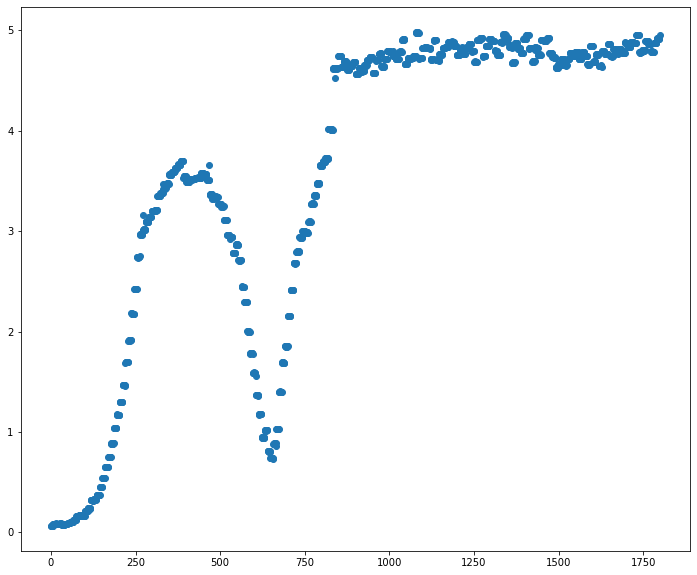

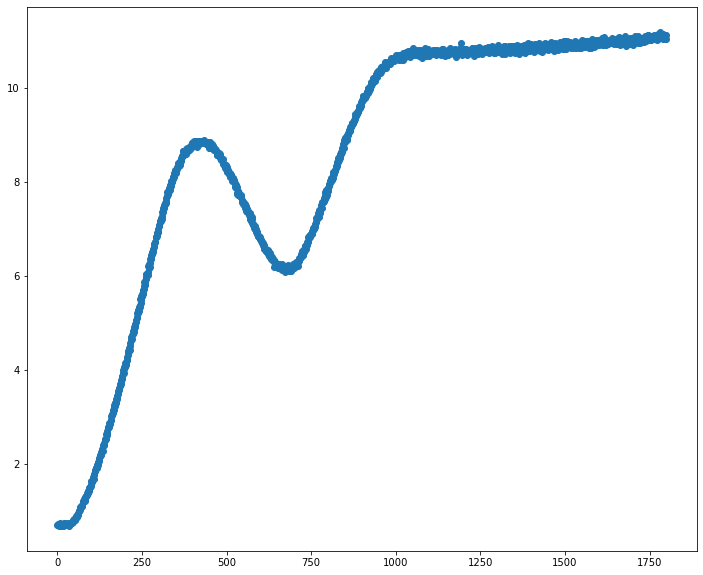

In [13]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
#STD = X.std(axis=2)
MAX_MIN = X.max(axis=2) - X.min(axis=2)
#MEAN = X.mean(axis=2)
#X_test = np.zeros((1,1800,2))
#X_test[:,:,0] = MEAN
#X_test[:,:,1] = STD
X_test = MAX_MIN
result = vae.predict(X_test)
#result = result[:,:,1]
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

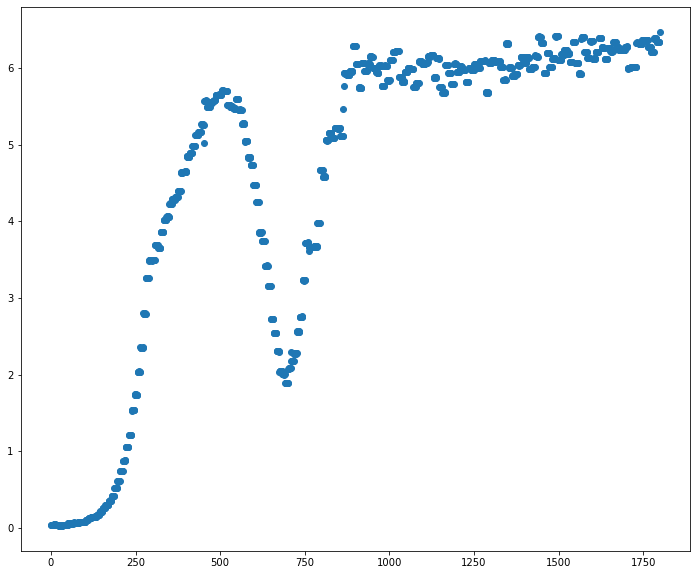

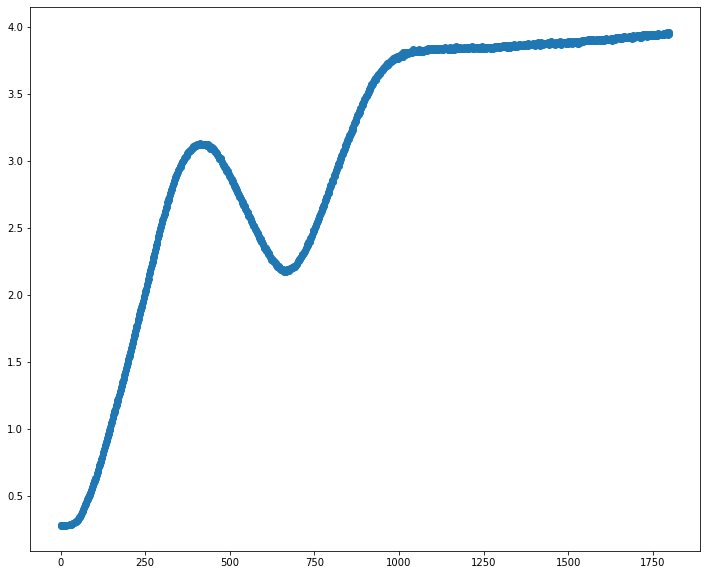

In [10]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
X = X.std(axis=2)
result = vae.predict(X)
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

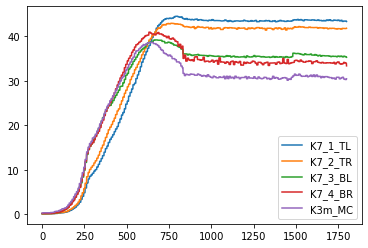

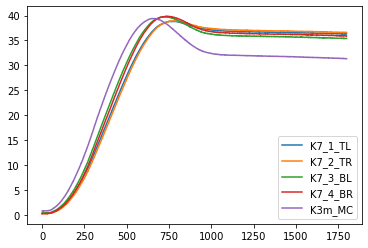

In [11]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

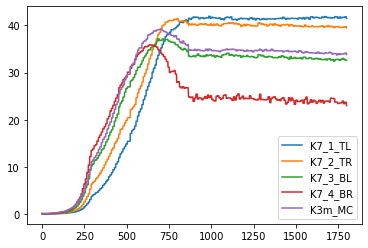

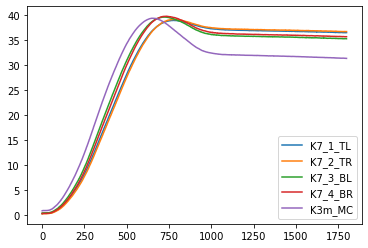

In [12]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

## find threshold

In [9]:
#find NOK ratio
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
#df_train = pd.read_csv('find_threshold.csv')
generator_train = CurveSequence(df_train, batch_size=1)

recon_error = keras.Model(encoder_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
result = recon_error.predict_generator(generator_train, workers=8, use_multiprocessing=True, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
52283/52283 [==============================] - 170s 3ms/step


In [10]:
not_ok = df_train[df_train.ResultFinalCheck == 'NOK']
ok = df_train[df_train.ResultFinalCheck == 'OK']
print(not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0]))
threshold=not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0])

0.005929269552244516


In [11]:
judge_loss = np.percentile(result,(1-threshold)*100)

In [12]:
print(judge_loss)

164.65499619117426


In [13]:
np.min(result)

0.26964292

In [14]:
np.max(result)

568.05334

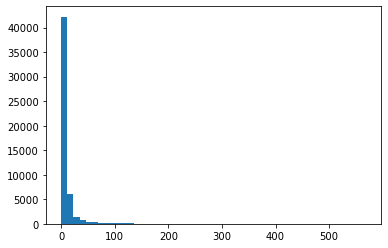

In [15]:
from matplotlib import pyplot as plt

plt.hist(result, 50) # bins = 50，顺便可以控制bin宽度
plt.show()

## Test on valid dataset

In [16]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [18]:
#valid set test
df_valid = pd.read_csv('clean_test_5_pec_30_pec.csv')
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_valid = CurveSequence(df_valid, batch_size=1)

recon_error = keras.Model(encoder_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
predict_valid = recon_error.predict_generator(generator_valid, workers=8, use_multiprocessing=True, verbose=1)

13071/13071 [==============================] - 41s 3ms/step


In [19]:
val_result = []
for i in range(len(predict_valid)):
    if predict_valid[i] > judge_loss:
        val_result.append(0)
    else:
        val_result.append(1)

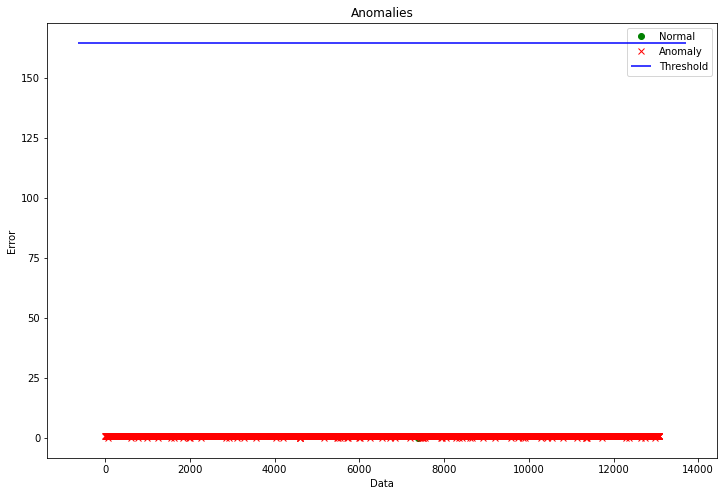

In [22]:
viz = Visualization()
viz.draw_anomaly(valid_y, val_result, judge_loss)

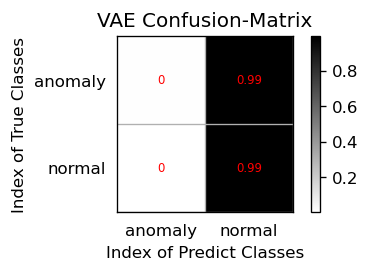

In [23]:
plot_confusion_matrix(valid_y, val_result, ['anomaly','normal'],'VAE Confusion-Matrix')

In [24]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
    print(n_false_positives, n_true_positives)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [25]:
print(compute_score(val_result, valid_y))

104 1
-7.924412822278326


## detect on test data

In [29]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,FilePath,Decision
0,MPC2_IM_L2/S42_P4/2019_01_10_03h/5c36c122_3113...,OK
1,MPC2_IM_L1/S42_P3/2019_02_05_20h/5c5a888f_2022...,OK
2,MPC2_IM_L1/S42_42/2018_10_22_04h/5bcdaaa8_2041...,OK
3,MPC2_IM_L3/S42_P3/2019_02_06_01h/5c5a5dee_3255...,OK
4,MPC2_IM_L2/S42_P2/2018_09_06_21h/5b9238fe_3092...,OK


In [27]:
df_test.shape

(561423, 2)

In [30]:
generator_test = CurveSequence(df_test, batch_size=1)
recon_error = keras.Model(encoder_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
predict = recon_error.predict_generator(generator_test, workers=4, use_multiprocessing=True, verbose=1)

561423/561423 [==============================] - 1357s 2ms/step


In [33]:
result = []
for i in range(len(predict)):
    if predict[i] > judge_loss:
        result.append('NOK')
    else:
        result.append('OK')

In [34]:
path_name = df_test['FilePath']
cont_list = {'FilePath':path_name, 'Decision':result}
df = pd.DataFrame(cont_list, columns=['FilePath','Decision'])
df.to_csv('jst.csv')